In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import os
os.environ["NUMBA_CACHE_DIR"] = r"C:\Users\HP\numba_cache"
import librosa
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import librosa
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import pandas as pd
#Read the CSV file, string containing file path
csv_file ='C:\\Users\\HP\\Desktop\\Audio Classification\\archive\\UrbanSound8K.csv'

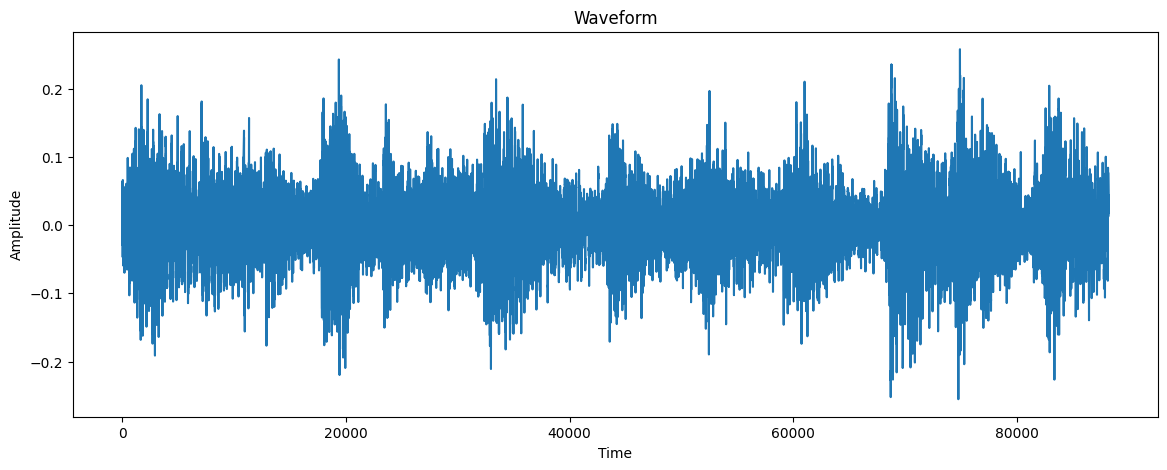

In [3]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
file_name='C:/Users/HP/Desktop/Audio Classification/archive/fold7/101848-9-0-3.wav'
#101848-9-0-3.wav
#reading and displaying
audio_data, sampling_rate = librosa.load(file_name)
plt.figure(figsize=(14, 5))
plt.plot(audio_data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

ipd.Audio(file_name)

In [4]:
# Read the CSV file into a pandas DataFrame
#data is a data frame
data = pd.read_csv(csv_file)
audio_files = data['slice_file_name'].tolist()

In [5]:
import os
import librosa
import numpy as np
# Define root directory and folders
root_directory = 'C:\\Users\\HP\\Desktop\\Audio Classification\\archive'
folders = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']
labels = []  # List to store the labels
dataframe = pd.read_csv(csv_file)
labels = dataframe['class']

In [6]:
import librosa
import numpy as np

# Convert audio data to spectrogram
n_mels = 128  # Adjust this value as needed
fmin = 0  # Adjust this value as needed
fmax = 8000  # Adjust this value as needed
window_size = 4  # Adjust this value as needed (in seconds),This variable sets the size of the sliding 
#window used for audio segmentation. It represents the length of each segment in seconds.

# Function to create sliding windows from audio data
def create_sliding_windows(data, sample_rate, window_size):
    window_length = int(window_size * sample_rate)
    num_windows = len(data) // window_length
    windows = [data[i * window_length : (i + 1) * window_length] for i in range(num_windows)]
    return windows

spectrograms = [] #computed mel spectrograms
window_labels = []  # List to store labels for each windowed spectrogram

# Loop over each folder
# Load the audio data from each file in the specified folders
for folder in folders:
    # Construct the folder path
    folder_path = os.path.join(root_directory, folder)
    
    # List all the audio files in the folder
    audio_files = os.listdir(folder_path)
    
    # Loop over each audio file
    for audio_file in audio_files:
        # Construct the file path
        file_path = os.path.join(folder_path, audio_file)
        
        try:
            data, sample_rate = librosa.load(file_path, sr=22050)
            windows = create_sliding_windows(data, sample_rate, window_size)
            
            for window in windows:
                # Convert audio data to spectrogram for each window
                spectrogram = librosa.feature.melspectrogram(y=window, sr=sample_rate, n_fft=4096, n_mels=n_mels, fmin=fmin, fmax=fmax)
                spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
                spectrograms.append(spectrogram)
                # Get the label for the current audio file
                label = dataframe.loc[dataframe['slice_file_name'] == audio_file, 'class'].values[0]
                window_labels.append(label)  # Store the label for each windowed spectrogram
            
        except Exception as e:
            print(f"Error processing file: {file_path}, {e}")

# Convert the list of spectrograms and window labels to numpy arrays
spectrograms = np.array(spectrograms)
window_labels = np.array(window_labels)

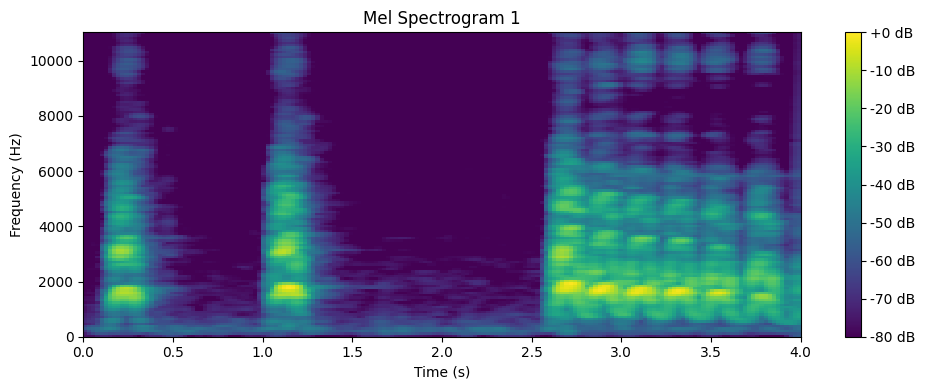

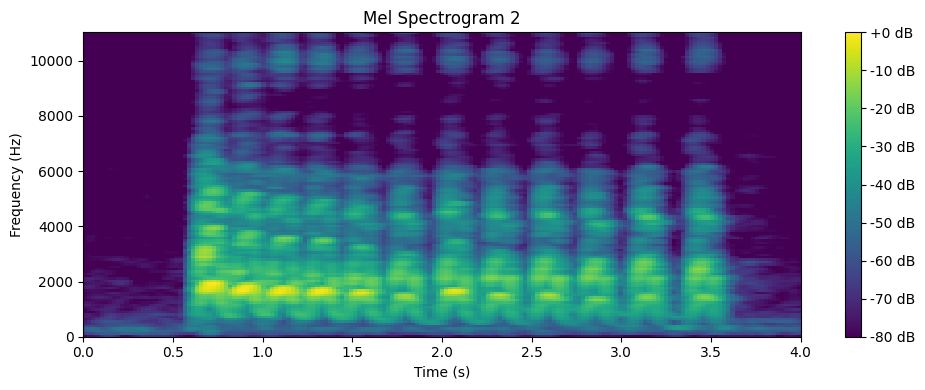

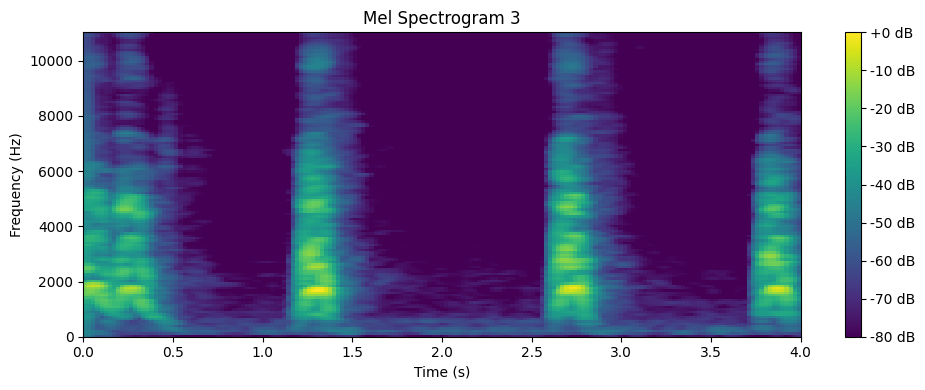

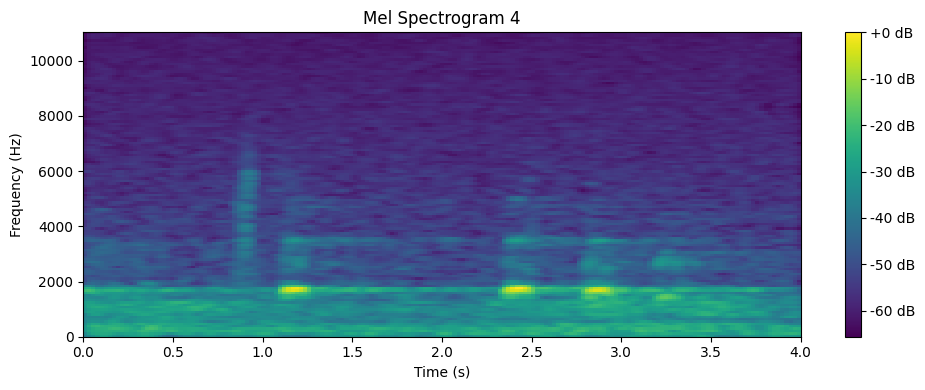

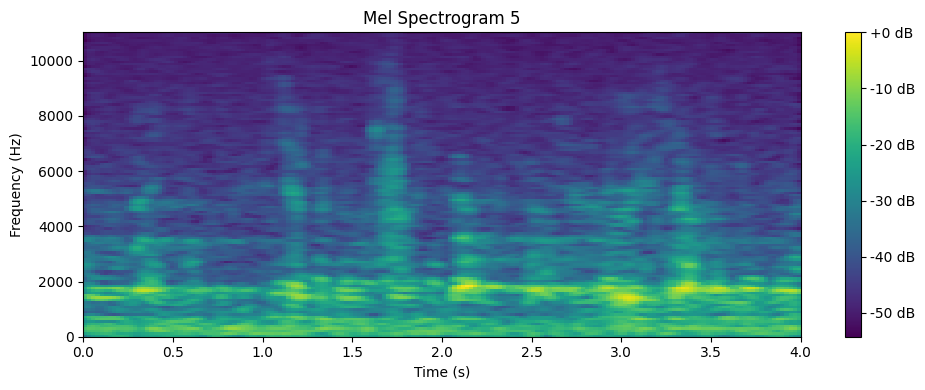

In [7]:
for i in range(5):
    spectrogram = spectrograms[i]
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, origin='lower', aspect='auto', cmap='viridis', 
               extent=[0, len(data) / sample_rate, 0, sample_rate / 2],
               interpolation='nearest')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(spectrograms, window_labels, test_size=0.2, random_state=42)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to numerical class indices
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
num_classes = len(label_encoder.classes_)
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

In [9]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_train_evaluate_cnn_model(X_train, y_train_encoded, X_test, y_test_encoded, num_classes, batch_size=32, epochs=40):
    # Build the CNN model with Batch Normalization
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())  # Add Batch Normalization after Dense
    model.add(Dense(64, activation='relu'))  # Add one more Dense layer
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test[..., np.newaxis], y_test_encoded)
    print(f'Test accuracy: {accuracy}')

    train_predict = model.predict(X_train[..., np.newaxis])
    test_predict = model.predict(X_test[..., np.newaxis])
    train_rmse = np.sqrt(np.mean((train_predict - y_train_encoded)**2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test_encoded)**2))
    print("Train RMSE: ", train_rmse)
    print("Test RMSE: ", test_rmse)
    return model, history

In [11]:
import matplotlib.pyplot as plt
import keras 
def plot_loss_and_accuracy(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()

# Assuming you already have X_train, y_train_encoded, X_test, y_test_encoded, num_classes, and the model defined
model, history = build_train_evaluate_cnn_model(X_train, y_train_encoded, X_test, y_test_encoded, num_classes)

# Plot the loss and accuracy curves
plot_loss_and_accuracy(history)


Epoch 1/40
147/147 [==============================] - 97s 649ms/step - loss: 2.1329 - accuracy: 0.2764 - val_loss: 2.2845 - val_accuracy: 0.1874
Epoch 2/40
147/147 [==============================] - 96s 652ms/step - loss: 1.6924 - accuracy: 0.4147 - val_loss: 2.0969 - val_accuracy: 0.2939
Epoch 3/40
147/147 [==============================] - 102s 693ms/step - loss: 1.4615 - accuracy: 0.5028 - val_loss: 1.6817 - val_accuracy: 0.4114
Epoch 4/40
  2/147 [..............................] - ETA: 1:45 - loss: 1.3053 - accuracy: 0.6094

KeyboardInterrupt: 

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape, BatchNormalization

def build_train_evaluate_cnn_lstm_model(X_train, y_train_encoded, X_test, y_test_encoded, num_classes, batch_size=32, epochs=1):
    # Build the CNN + LSTM model with regularization and Batch Normalization
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())  # Add Batch Normalization after Conv2D

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Add Batch Normalization after Dense

    # Reshape the output of the Flatten layer to add a time step dimension
    model.add(Reshape((1, -1)))

    # Add the first LSTM layer with 128 units
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Add Batch Normalization after LSTM

    # Add the second LSTM layer with 64 units
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())  # Add Batch Normalization after LSTM

    model.add(Dense(num_classes, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train[..., np.newaxis], y_train_encoded, batch_size=batch_size, epochs=1, validation_split=0.2)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test[..., np.newaxis], y_test_encoded)
    print(f'Test accuracy: {accuracy}')

    train_predict = model.predict(X_train[..., np.newaxis])
    test_predict = model.predict(X_test[..., np.newaxis
                                       ])
    train_rmse = np.sqrt(np.mean((train_predict - y_train_encoded)**2))
    test_rmse = np.sqrt(np.mean((test_predict - y_test_encoded)**2))
    print("Train RMSE: ", train_rmse)
    print("Test RMSE: ", test_rmse)
    return model, history

In [ ]:
# Plot the loss and accuracy curves
def plot_loss_and_accuracy(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curve')
    plt.show()
# already have X_train, y_train_encoded, X_test, y_test_encoded, num_classes, and the model defined
model, history = build_train_evaluate_cnn_model(X_train, y_train_encoded, X_test, y_test_encoded, num_classes)
plot_loss_and_accuracy(history)